In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport utils, GroupingAlgorithm

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from utils import number2SummedOp, Label2Chain
from qiskit.algorithms import NumPyMinimumEigensolver
%matplotlib widget

# $H_20$ grouping vs $x$ (w/ shuffle)

In [2]:
file = 'H20_grouping_shuffle_ideal_vs_connectivity'
data = np.load(file + '.npy', allow_pickle=True).item()

print(data.keys())

for key in data:
    vars()[key] = data[key]

dict_keys(['x_vec', 'n_groups', 'optimal_order_paulis', 'optimal_order_qubits', 'optimal_graph'])


In [3]:
n_x = len(x_vec)

n_std = np.zeros(n_x)
n_avg = np.zeros(n_x)
n_min = np.zeros(n_x)
n_max = np.zeros(n_x)

for i in range(n_x):
    n_std[i] = np.std(n_groups[i])
    n_avg[i] = np.mean(n_groups[i])
    n_min[i] = np.min(n_groups[i])
    n_max[i] = np.max(n_groups[i])

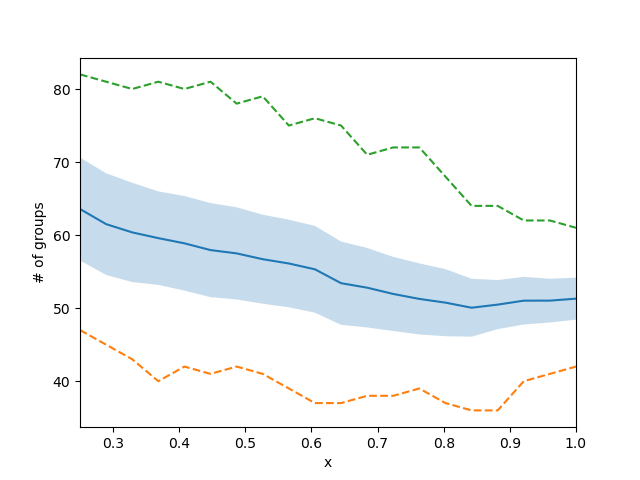

In [4]:
fig, ax = plt.subplots()
ax.plot(x_vec, n_avg)
ax.fill_between(x_vec, n_avg - n_std, n_avg + n_std, alpha=0.25)
ax.plot(x_vec, n_min, '--')
ax.plot(x_vec, n_max, '--')
ax.set_xlabel('x')
ax.set_ylabel('# of groups')
ax.set_xlim([x_vec[0], x_vec[-1]]);

In [5]:
index_min = np.argmin(n_min)
print('The minumum number of groups is {:.0f}, obtained for x = {:.3f}'.format(n_min[index_min], x_vec[index_min]))

The minumum number of groups is 36, obtained for x = 0.842


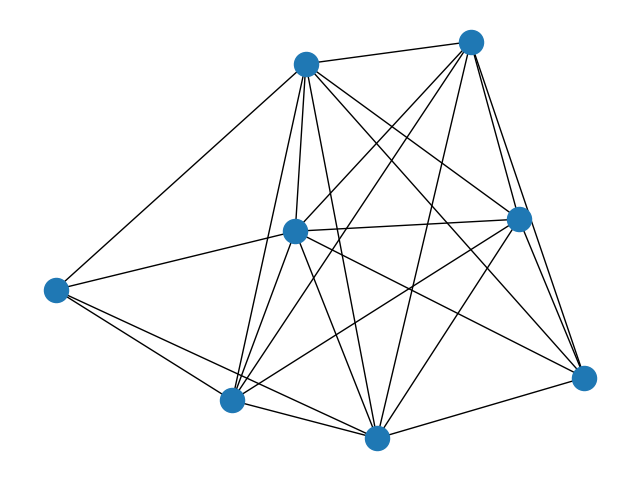

In [14]:
plt.figure()
nx.draw(optimal_graph[index_min])

# Optimal VQE

In [2]:
molecule = 'BeH2'
name_backend = 'ibmq_montreal'
data = np.load('../data/VQE_' + molecule + '_ibmq_montreal.npy', allow_pickle=True).item()

data_qubit_op = np.load('../data/optimal_grouping_' + molecule + '_' + name_backend + '.npy', allow_pickle=True).item()
qubit_op = number2SummedOp(data_qubit_op['optimal_labels'], data_qubit_op['optimal_coeffs'])
num_qubits = qubit_op.num_qubits
paulis, _, _ = Label2Chain(qubit_op)

n_groups = data_qubit_op['n_groups']

result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
print('The exact energy is: {:.3f}'.format(np.real(result_exact.eigenvalue)))

The exact energy is: -3.911


In [7]:
labels = ['TPB', 'EM', 'HEEM']
x_axis = 'iterations'

fig, ax = plt.subplots()
for label in labels:    
    energies_temp = data[label][:, 50:]
    energies = np.zeros([energies_temp.shape[0], energies_temp.shape[1] // 2])
    for i in range(energies_temp.shape[1] // 2):
        energies[:, i] = np.mean(energies_temp[:, 2 * i: 2 * i + 2], axis=1)
    
    
    x_vec = np.arange(0, len(energies[0]))
    if x_axis == 'circuits':
        x_vec *= n_groups[label]
    
    std = np.std(energies, axis=0)
    avg = np.mean(energies, axis=0)
    
    line = ax.plot(x_vec, avg, label=label)
    ax.fill_between(x_vec, avg - std, avg + std, alpha=0.2)
    for i in range(2):
        ax.plot(x_vec, avg + (-1) ** i * std, ls='-', alpha=0.5, c=line[0].get_color())

ax.plot([np.real(result_exact.eigenvalue)] * len(avg) * n_groups['TPB'], 'k--', label='Exact')

if x_axis == 'iterations':
    ax.set_xlabel('iterations')
    ax.set_xlim([0, (len(std) - 1)])
elif x_axis == 'circuits':
    ax.set_xlabel('number of circuits')
    ax.set_xlim([0, (len(std) - 1) * n_groups['TPB']])
    
ax.set_ylabel('energy [Ha]')
ax.legend()
ax.set_title(molecule);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …